In [1]:
%pylab inline
import random
import cv2
import pandas as pd
import os
from glob import glob

Populating the interactive namespace from numpy and matplotlib


Steering angle distribution
===========================

In [2]:
dataDIR = 'data'
logFile = os.path.join(dataDIR, 'driving_log.csv')
raw_data = pd.read_csv(logFile)
raw_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG\center_2016_12_01_13_30_48_287.jpg,IMG\left_2016_12_01_13_30_48_287.jpg,IMG\right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG\center_2016_12_01_13_30_48_404.jpg,IMG\left_2016_12_01_13_30_48_404.jpg,IMG\right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG\center_2016_12_01_13_31_12_937.jpg,IMG\left_2016_12_01_13_31_12_937.jpg,IMG\right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG\center_2016_12_01_13_31_13_037.jpg,IMG\left_2016_12_01_13_31_13_037.jpg,IMG\right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG\center_2016_12_01_13_31_13_177.jpg,IMG\left_2016_12_01_13_31_13_177.jpg,IMG\right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
print('Number of images per camera in the log file: {}'.format(
                                                    raw_data.shape[0]))

Number of images per camera in the log file: 9913


In [4]:
raw_data['steering'].describe()

count    9913.000000
mean       -0.005174
std         0.132808
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

The data is skewed towards small steering angles. Below is the histogram on linear scale and log scale to confirm this observation.

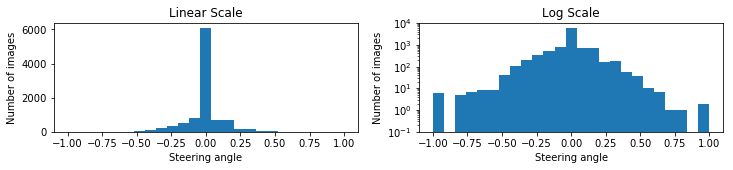

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 2))
for ax in axes:
    ax.hist(raw_data['steering'], bins=25)
    ax.set_xlabel('Steering angle')
    ax.set_ylabel('Number of images')
    
axes[1].set_ylim([0.1, 10000])
axes[1].set_yscale('log')
axes[1].set_title('Log Scale')
axes[0].set_title('Linear Scale')
plt.show()

Let's check if the images in the dataset are actually consistent with the information in the log file:

In [6]:
left_img_files = glob(os.path.join(dataDIR, 'IMG\\left*.jpg'))
center_img_files = glob(os.path.join(dataDIR, 'IMG\\center*.jpg'))
right_img_files = glob(os.path.join(dataDIR, 'IMG\\right*.jpg'))

In [7]:
# Check if every shot has all the three camera angles and no images 
#are missing

for center_file in center_img_files:
    base_path, img_index = center_file.split('center_')
    left_file = os.path.join(base_path, 'left_' + img_index)
    right_file = os.path.join(base_path, 'right_' + img_index)
    assert left_file in left_img_files, left_file+' missing'
    assert right_file in right_img_files, right_file+' missing'
    
print("All shots have three camera angles.")

All shots have three camera angles.


In [8]:
number_of_images = len(center_img_files)
print('{} images in the image dataset for each camera angle'.format(
                                                     number_of_images))

assert number_of_images == raw_data.shape[0], 'Number of images do not\
                                              match with that in log file'
print('Number of images consistent with log file')

# get sample image size
img = cv2.imread(center_img_files[0])
print('Size of a sample image is : {}'.format(img.shape))

9913 images in the image dataset for each camera angle
Number of images consistent with log file
Size of a sample image is : (160, 320, 3)


Some Image visualization
========================

## Helper function to display three random images for each of the three camera angles

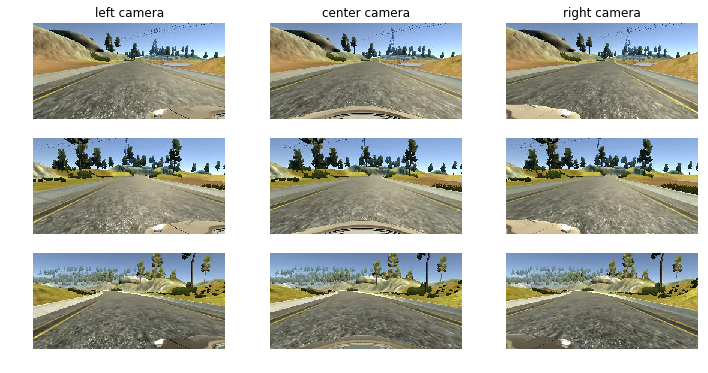

In [9]:
camera_positions = ['left','center','right']

class generate_image :
    def __init__(self, img_index, camera_position='center') :
        self.img_data = raw_data.iloc[img_index]
        self.steer = self.img_data['steering']
        file_name = os.path.join(dataDIR,self.img_data[camera_position].strip())
        img = cv2.imread(file_name)
        self.image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


# display random images for different camera angles
fig, axes = plt.subplots(3, 3, figsize=(12,6))
for pos,ax in zip(camera_positions, axes[0,:]):
    ax.set_title(pos+' camera')
for ax in axes :
    img_index = random.randrange(number_of_images)
    for a, pos in zip(ax, camera_positions) :
        img = generate_image(img_index, camera_position=pos)
        a.imshow(img.image)
        a.axis('off')

Data Preprocessing
=======================

Extreme steering angles can negatively effect training in the later stages, so we want to make sure these are genuine cases. Below we plot these outliers :


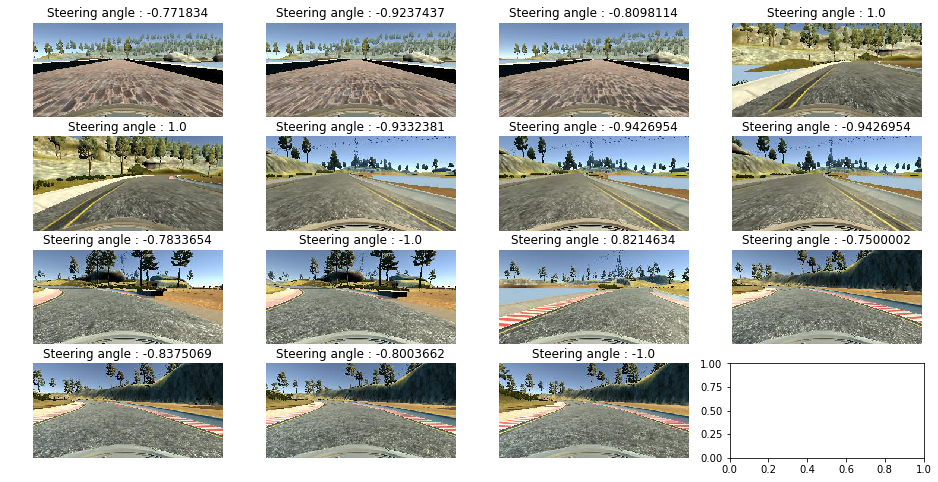

In [10]:
# visualize extreme steering angles
extreme_angles = raw_data.loc[(raw_data['steering']<-0.75) | (raw_data['steering']>0.75)].index

ncols = 4
nrows = int(np.ceil(len(extreme_angles)/ncols))
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2*nrows))
for ax,img_index in zip(axes.flatten(), extreme_angles) :
    img = generate_image(img_index)
    ax.imshow(img.image)
    ax.set_title('Steering angle : '+str(img.steer))
    ax.axis('off')

In the first three images, the car seems to be fairly in the center of the road while steering angles look suspiciously high.

Therefore, we pad the steering angle to -0.8:

In [11]:
# Remove unnecessary info
data = raw_data
data = data.drop(['throttle', 'speed', 'brake'], axis=1)

# Pad extreme steering angles
for i in extreme_angles[0:3]:
    data.loc[i, 'steering'] = -0.8
    
nb_imgs = data.shape[0]
print('Number of images in dataset: {}'.format(nb_imgs))
data.describe()


Number of images in dataset: 9913


,steering
count,9913.000000
mean,-0.005163
std,0.132738
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Bin the images according to steering angles. By binning the images, we remove the bias towards low steering angles in the dataset. 

The selection probability of bins is determined by Gaussian distribution as shown below :

In [12]:
from scipy.stats import norm 

nb_steer_bins = 25
steer_bins = np.linspace(-1.,1.001,nb_steer_bins+1)
steer_bin_index = list(range(1,nb_steer_bins+1))
data_bin_index = np.digitize(data['steering'], steer_bins) 
assert len(data_bin_index)==nb_imgs, "Check bins."

In [13]:
# selection probability for each bin
steer_bin_prob = np.array([norm.pdf(x, scale=.8) for x in steer_bins])
steer_bin_prob = {i:steer_bin_prob[i-1]/np.sum(steer_bin_prob) 
                  for i in steer_bin_index} 

In [14]:
# selection probability for each image 
img_prob = np.zeros(nb_imgs)

data_steer_bins = {steer_bin : [] for steer_bin in steer_bin_index}
for i in range(nb_imgs) :
    key = data_bin_index[i]
    data_steer_bins[key].append(i)

sum = 0
for index in steer_bin_index :
    bin_size = len(data_steer_bins[index])
    p_bin = steer_bin_prob[index]
    print("bin {:2} : {: .2f} < steering angle < {: .2f} : size = {:4} images :\
           selection probability = {:.3f}"
          .format(index, steer_bins[index-1], steer_bins[index],
                  bin_size, p_bin))
    sum += bin_size
    for i in data_steer_bins[index] :
        img_prob[i] = p_bin/bin_size
print("Total images : {}".format(sum))

bin  1 : -1.00 < steering angle < -0.92 : size =    5 images :           selection probability = 0.023
bin  2 : -0.92 < steering angle < -0.84 : size =    0 images :           selection probability = 0.026
bin  3 : -0.84 < steering angle < -0.76 : size =    6 images :           selection probability = 0.029
bin  4 : -0.76 < steering angle < -0.68 : size =    7 images :           selection probability = 0.032
bin  5 : -0.68 < steering angle < -0.60 : size =    8 images :           selection probability = 0.034
bin  6 : -0.60 < steering angle < -0.52 : size =    8 images :           selection probability = 0.037
bin  7 : -0.52 < steering angle < -0.44 : size =   43 images :           selection probability = 0.040
bin  8 : -0.44 < steering angle < -0.36 : size =  101 images :           selection probability = 0.043
bin  9 : -0.36 < steering angle < -0.28 : size =  200 images :           selection probability = 0.045
bin 10 : -0.28 < steering angle < -0.20 : size =  331 images :           

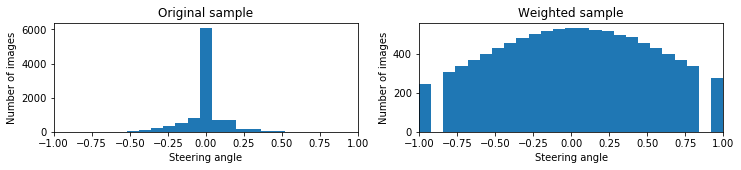

In [15]:
sum_wt = np.sum(img_prob)
fig, axes = plt.subplots(1, 2, figsize=(12, 2))
axes[0].hist(raw_data['steering'], bins=25)
axes[1].hist(data['steering'], bins=25,
            weights=[nb_imgs*img_prob[i]/sum_wt 
                    for i in range(nb_imgs)])

for ax in axes:
    ax.set_xlabel('Steering angle')
    ax.set_ylabel('Number of images')
    ax.set_xlim([-1, 1])
    
axes[0].set_title('Original sample')
axes[1].set_title('Weighted sample')
plt.show()

As a final for the image preprocessing, we apply the following steps:

- **Crop image** : Crop the bottom 24 pixels to remove the car hood and the top 30 pixels to remove things above horizon (such as sky etc.)
- **Contrast normalization** : Convert to YUV colorspace and apply histogram equilization on the Y channel for contrast enhancement (helps with day/night driving) and then convert back to RGB. All color channels are then normalized so that array values lie between -0.5 and 0.5
- **Resize image** : All images are resized to 200x66 pixels. The initial layers of our Architecture will be similar to NVIDIA architecture which happens to use 66x200x3 dimensional input tensor.

In [16]:
# This will be in the input tensor dimensions for our CNN
input_shape = (66,200,3)

# some functions for image preprocessing 
def crop_img(img, top=30, bottom=24, left=0, right=0) :
    h,w,_ = img.shape
    return img[top:h-bottom,left:w-right]

def MinMaxNorm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def AbsNorm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def contrast_norm(image) :
    """
    Applies histogram equilization on Y channel of YUV
    and returns normalized BGR image
    """
    # convert to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    new_image[:,:,0] = cv2.equalizeHist(new_image[:,:,0])
    new_image = cv2.cvtColor(new_image, cv2.COLOR_YUV2BGR)
    return AbsNorm(new_image)

def resize_img(img, new_size=(200,66)) :
    return cv2.resize(img, new_size, interpolation = cv2.INTER_AREA)

def preprocess(img) : 
    new_img = crop_img(img)
    new_img = contrast_norm(new_img)
    return resize_img(new_img)

Image Preprocessing Pipeline in action
======================================

In [17]:
def display_preprocess_pipeline(images) :
    """
    Displays preprocessing pipeline for list of images
    """
    nrows = len(images)
    fig, axes = plt.subplots(nrows, 4, figsize=(15,2*nrows))
    
    # pre-processing pipeline
    pipeline = ['Original','Crop','Contrast Norm','Resize']
    
    # plot pipeline
    for ax, p in zip(axes[0,:], pipeline) :
        ax.set_title(p)
    for ax,img in zip(axes,images) :
        ax[0].imshow(img)
        img = crop_img(img)
        ax[1].imshow(img)
        img = contrast_norm(img)
        ax[2].imshow(img)
        img = resize_img(img)
        ax[3].imshow(img)
        for a in ax :
            a.axis('off')

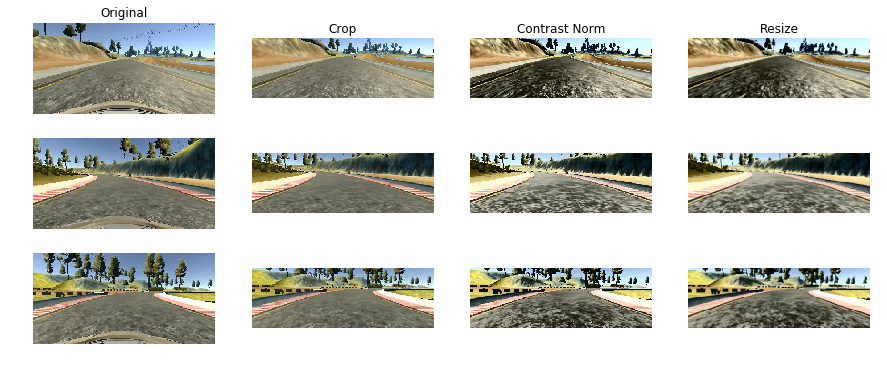

In [18]:
img_list = [generate_image(random.randrange(nb_imgs)).image for i in range(3)]
display_preprocess_pipeline(img_list)